In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  

In [2]:
mnist = input_data.read_data_sets('D:/python_code/MNIST_data', one_hot=True)
train_X   = mnist.train.images
train_Y = mnist.train.labels
test_X    = mnist.test.images
test_Y  = mnist.test.labels

Extracting D:/python_code/MNIST_data\train-images-idx3-ubyte.gz
Extracting D:/python_code/MNIST_data\train-labels-idx1-ubyte.gz
Extracting D:/python_code/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting D:/python_code/MNIST_data\t10k-labels-idx1-ubyte.gz


In [3]:
#define network
# NETOWRK PARAMETERS
n_input    = 784 
n_hidden_1 = 256 
n_hidden_2 = 256 
n_output   = 784  

# PLACEHOLDERS
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_output])
dropout_keep_prob = tf.placeholder("float")

# WEIGHTS
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_output]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_output]))
}

# MODEL
def denoise_auto_encoder(_X, _weights, _biases, _keep_prob):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_1out = tf.nn.dropout(layer_1, _keep_prob) 
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1out, _weights['h2']), _biases['b2'])) 
    layer_2out = tf.nn.dropout(layer_2, _keep_prob) 
    return tf.nn.sigmoid(tf.matmul(layer_2out, _weights['out']) + _biases['out'])

# MODEL AS A FUNCTION
reconstruction = denoise_auto_encoder(x, weights, biases, dropout_keep_prob)
print ("NETOWRK READY")

NETOWRK READY


In [5]:
#define function

# COST
cost = tf.reduce_mean(tf.pow(reconstruction-y, 2))
# OPTIMIZER
optm = tf.train.AdamOptimizer(0.01).minimize(cost) 
# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

FUNCTIONS READY


In [6]:
savedir = "D:/python_code/model/autoencoder/"
saver   = tf.train.Saver(max_to_keep=1)
print ("SAVER READY")

SAVER READY


START OPTIMIZATION
Epoch 00/50 average cost: 0.093224


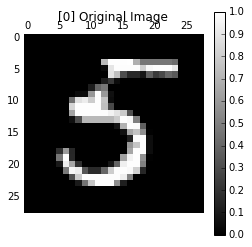

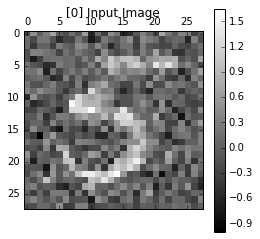

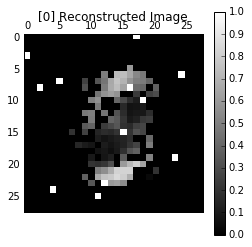

Epoch 10/50 average cost: 0.078632


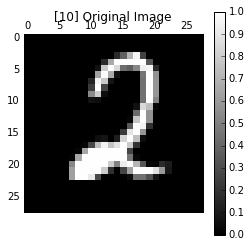

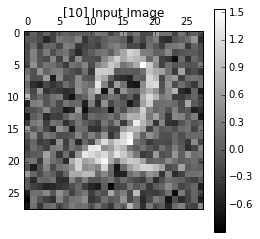

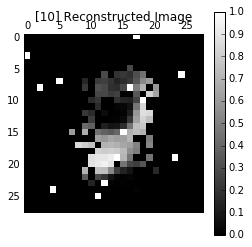

Epoch 20/50 average cost: 0.077759


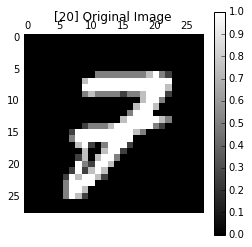

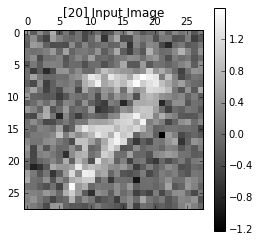

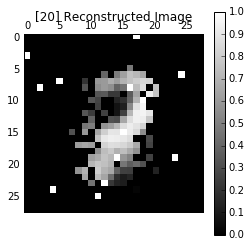

Epoch 30/50 average cost: 0.076998


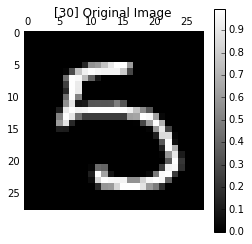

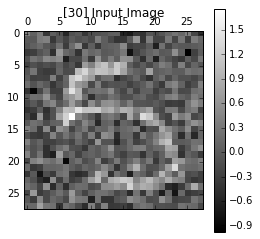

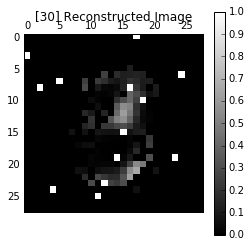

Epoch 40/50 average cost: 0.076562


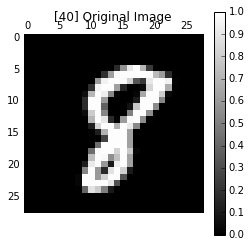

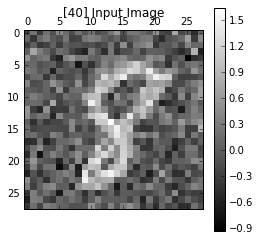

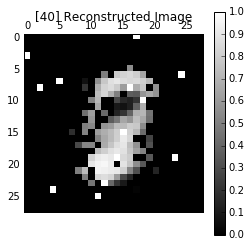

OPTIMIZATION FINISHED


In [7]:
#train
TRAIN_FLAG = 1
epochs     = 50
batch_size = 100
disp_step  = 10

sess = tf.Session()
sess.run(init)
if TRAIN_FLAG:
    print ("START OPTIMIZATION")
    for epoch in range(epochs):
        num_batch  = int(mnist.train.num_examples/batch_size)
        total_cost = 0.
        for i in range(num_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            batch_xs_noisy = batch_xs + 0.3*np.random.randn(batch_size, 784) #加噪声
            feeds = {x: batch_xs_noisy, y: batch_xs, dropout_keep_prob: 1.}
            sess.run(optm, feed_dict=feeds)
            total_cost += sess.run(cost, feed_dict=feeds)
        # DISPLAY
        if epoch % disp_step == 0:
            print ("Epoch %02d/%02d average cost: %.6f" 
                   % (epoch, epochs, total_cost/num_batch))
            # PLOT
            randidx  = np.random.randint(test_X.shape[0], size=1)
            testvec  = test_X[randidx, :]
            noisyvec = testvec + 0.3*np.random.randn(1, 784)
            outvec   = sess.run(reconstruction, feed_dict={x: testvec, dropout_keep_prob: 1.})
            outimg   = np.reshape(outvec, (28, 28))
            # Plot 
            plt.matshow(np.reshape(testvec, (28, 28)), cmap=plt.get_cmap('gray'))
            plt.title("[" + str(epoch) + "] Original Image")
            plt.colorbar()
            plt.show()
            plt.matshow(np.reshape(noisyvec, (28, 28)), cmap=plt.get_cmap('gray'))
            plt.title("[" + str(epoch) + "] Input Image")
            plt.colorbar()
            plt.show()
            plt.matshow(outimg, cmap=plt.get_cmap('gray'))
            plt.title("[" + str(epoch) + "] Reconstructed Image")
            plt.colorbar()
            plt.show()
        # SAVE
        saver.save(sess, savedir + 'denoise_auto_encoder.ckpt', global_step=epoch)
print ("OPTIMIZATION FINISHED")

In [11]:
c=  np.random.randint(5, size=1)

In [12]:
print (c)

[4]


In [13]:
# Restore
load_epoch = 49
saver.restore(sess, "D:/python_code/model/autoencoder/denoise_auto_encoder.ckpt-" + str(load_epoch))

INFO:tensorflow:Restoring parameters from D:/python_code/model/autoencoder/denoise_auto_encoder.ckpt-49


label is 7
Salt and Pepper Noise


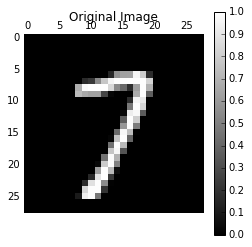

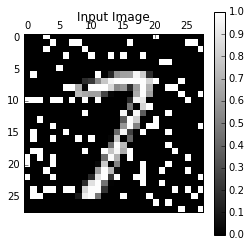

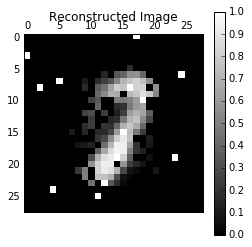

In [14]:
# Test one
randidx   = np.random.randint(test_X.shape[0], size=1)
orgvec    = test_X[randidx, :]
testvec   = test_X[randidx, :]
label     = np.argmax(test_Y[randidx, :], 1)

print ("label is %d" % (label)) 
# Noise type
ntype = 2 # 1: Gaussian Noise, 2: Salt and Pepper Noise
if ntype is 1:
    print ("Gaussian Noise")
    noisyvec = testvec + 0.3*np.random.randn(1, 784)
else:    
    print ("Salt and Pepper Noise")
    noisyvec = testvec
    rate     = 0.15
    noiseidx = np.random.randint(test_X.shape[1]
                                 , size=int(test_X.shape[1]*rate))
    noisyvec[0, noiseidx] = 1-noisyvec[0, noiseidx]

outvec   = sess.run(reconstruction, feed_dict={x: noisyvec, dropout_keep_prob: 1})
outimg   = np.reshape(outvec, (28, 28))

# Plot 
plt.matshow(np.reshape(orgvec, (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("Original Image")
plt.colorbar()

plt.matshow(np.reshape(noisyvec, (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("Input Image")
plt.colorbar()

plt.matshow(outimg, cmap=plt.get_cmap('gray'))
plt.title("Reconstructed Image")
plt.colorbar()
plt.show() 

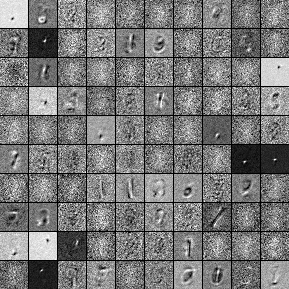

In [15]:
# Visualize Filter 
from PIL import Image

def scale_to_unit_interval(ndar, eps=1e-8):
    """ Scales all values in the ndarray ndar to be between 0 and 1 """
    ndar = ndar.copy()
    ndar -= ndar.min()
    ndar *= 1.0 / (ndar.max() + eps)
    return ndar

def tile_raster_images(X, img_shape, tile_shape, tile_spacing=(0, 0),
                       scale_rows_to_unit_interval=True,
                       output_pixel_vals=True):
    assert len(img_shape) == 2
    assert len(tile_shape) == 2
    assert len(tile_spacing) == 2
    out_shape = [(ishp + tsp) * tshp - tsp for ishp, tshp, tsp
                      in zip(img_shape, tile_shape, tile_spacing)]

    if isinstance(X, tuple):
        assert len(X) == 4
        # Create an output numpy ndarray to store the image
        if output_pixel_vals:
            out_array = np.zeros((out_shape[0], out_shape[1], 4), dtype='uint8')
        else:
            out_array = np.zeros((out_shape[0], out_shape[1], 4), dtype=X.dtype)

        #colors default to 0, alpha defaults to 1 (opaque)
        if output_pixel_vals:
            channel_defaults = [0, 0, 0, 255]
        else:
            channel_defaults = [0., 0., 0., 1.]

        for i in range(4):
            if X[i] is None:
                # if channel is None, fill it with zeros of the correct
                # dtype
                out_array[:, :, i] = np.zeros(out_shape,
                      dtype='uint8' if output_pixel_vals else out_array.dtype
                      ) + channel_defaults[i]
            else:
                # use a recurrent call to compute the channel and store it
                # in the output
                out_array[:, :, i] = tile_raster_images(X[i], img_shape, tile_shape, tile_spacing, scale_rows_to_unit_interval, output_pixel_vals)
        return out_array

    else:
        # if we are dealing with only one channel
        H, W = img_shape
        Hs, Ws = tile_spacing

        # generate a matrix to store the output
        out_array = np.zeros(out_shape, dtype='uint8' if output_pixel_vals else X.dtype)


        for tile_row in range(tile_shape[0]):
            for tile_col in range(tile_shape[1]):
                if tile_row * tile_shape[1] + tile_col < X.shape[0]:
                    if scale_rows_to_unit_interval:
                        # if we should scale values to be between 0 and 1
                        # do this by calling the `scale_to_unit_interval`
                        # function
                        this_img = scale_to_unit_interval(X[tile_row * tile_shape[1] + tile_col].reshape(img_shape))
                    else:
                        this_img = X[tile_row * tile_shape[1] + tile_col].reshape(img_shape)
                    # add the slice to the corresponding position in the
                    # output array
                    out_array[
                        tile_row * (H+Hs): tile_row * (H + Hs) + H,
                        tile_col * (W+Ws): tile_col * (W + Ws) + W
                        ]= this_img * (255 if output_pixel_vals else 1)
        return out_array

# Visualize filter
w1 = sess.run(weights["h1"])
image = Image.fromarray(tile_raster_images(
        X = w1.T,
        img_shape=(28, 28), tile_shape=(10, 10),
        tile_spacing=(1, 1)))
image